## Resolución EDO




# Resolución de una EDO Simple

Consideramos una ecuación diferencial ordinaria (EDO) con condición inicial:

$$
\begin{cases}
y'(t) = 2t, \\
y(0) = y_0,
\end{cases}
$$
donde $y_0 = 3$ y $t \in [0,4]$.

La solución exacta de esta EDO es:

$$
y(t) = x^2+3.
$$

A continuación, definimos el código utilizando *PyTorch*:

In [239]:
# Importar librerias
import numpy as np                 # Manejo de vectores y matrices (arrays)
import torch                       # Biblioteca principal para cálculo tensorial y redes neuronales
import torch.nn as nn              # Componentes para construir redes neuronales (capas, activaciones)
import torch.optim as optim        # Algoritmos de optimización para ajustar parámetros de la red
import torch.nn.init as init       # Métodos para inicializar pesos de redes neuronales
import torch.autograd as grad      # Cálculo automático de derivadas (gradientes)
import matplotlib.pyplot as plt    # Herramientas para visualización gráfica de resultados
import time                        # Funciones para medir tiempos de ejecución
import math                        # Funciones matemáticas elementales (trigonometría, exponenciales, etc.)

In [240]:
# Semilla fijada
torch.manual_seed(1234)

In [241]:
# Datos
t0 = 0;            # Tiempo inicial
tf = 4;            # Tiempo final
y0 = 3;            # Condición inicial
Nf = 1000          # Número de puntos para evaluar el residuo (error)
print_freq = 2000  # Frecuencia para imprimir información durante el entrenamiento

In [242]:
# Solución exacta
def exacta(x):
    y0 = 3      # Condición inicial
    return x**2 + y0

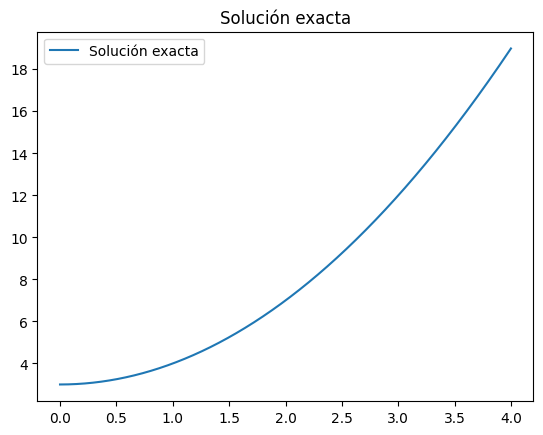

In [243]:
n = 4000
h = (tf-t0)/n

texact = torch.arange(t0,tf,h)
texact
yexact = exacta(texact)
plt.figure()
plt.plot(texact,yexact,label="Solución exacta")
plt.legend()
plt.title("Solución exacta")
plt.show()

### Definición Red Neuronal

In [244]:
class PINN(nn.Module):     # Clase para la red neuronal PINN

    def __init__(self, input_size, hidden_size, output_size):    # Inicializador

        super(PINN, self).__init__()                             # Inicializador de la clase base nn.Module


        # Definición de las capas de la red neuronal (3 capas lineales)
        #  nn.Linear(input_size, hidden_size)
        #  input_size : cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: cantidad de salidas (neuronas en la capa actual)
        # Capa lineal => salida = Entradas × Pesos + Sesgo

        # Capa 1: Entrada con input_size características, salida con hidden_size características
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Entrada con hidden_size características, salida con 1 característica
        self.fc3 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos:
        # 1) Random Initialization
        # Los pesos de las capas se inicializan con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # ó
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # 2) Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica
        # Ayuda a mantener una varianza constante a través de las capas
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

        # 3) He Initialization:
        # Ajustada para su uso con funciones de activación ReLU (Rectified Linear Unit).
        #nn.init.kaiming_normal_(model.fc1.weight)
        #nn.init.kaiming_normal_(model.fc2.weight)
        #nn.init.kaiming_normal_(model.fc3.weight)

        # Inicialización de sesgos:
        nn.init.zeros_(self.fc1.bias.data)
        nn.init.zeros_(self.fc2.bias.data)
        nn.init.zeros_(self.fc3.bias.data)

    def forward(self, x):
       # Propagación hacia adelante
       # Método forward:
       # - toma la entrada x
       # - pasa a través de las capas fc1, fc2 y fc3
       # (utiliza la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas)
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = self.fc3(x)             # No aplicamos función de activación en la última capa fc3

       return x

### - Datos de entrenamiento:

In [245]:
print(texact.shape)              # Forma del tensor de tiempos (entrada)
print(yexact.shape)              # Forma del tensor de valores exactos (salida)

# Selección de todos los puntos (con paso 1)
t = texact[::1]
y = yexact[::1]

# Conversión a tensores 2D (columnas)
t = torch.Tensor(t).view(-1,1)   # Entrada como vector columna
y = torch.Tensor(y).view(-1,1)   # Salida como vector columna

t.shape                          # Nueva forma del tensor t

torch.Size([4000])
torch.Size([4000])


torch.Size([4000, 1])

In [246]:
# Número (deseado) de datos para el entrenamiento (ajustable)
#k = 30
#k = 100
#k = 3
#k = 17
#k = 5
k = 12

k1 = k+1             # (opcional, si se requiere un punto adicional)
j = math.ceil(n/k)   # Tamaño del paso: espaciado uniforme en los datos originales
print(j)

j = j-1              # Ajuste fino del paso (evita tomar el último punto fuera de rango)

# Selección de subconjunto de datos de entrenamiento a partir del conjunto completo
# Tomamos 1 punto cada 'j' posiciones
t_data = t[::j]      # Tiempos de entrenamiento
y_data = y[::j]      # Valores exactos correspondientes

# t_data = t[::500]
# y_data = y[::500]

# Forma de los datos de entrenamiento
t_data.shape, y_data.shape

# Tomamos 17, peor que 20
#t_data = t[::236]
#y_data = y[::236]

# Tomamos 30, parece que hay sobreentrenamiento
#t_data = t[::134]
#y_data = y[::134]

# Tomamos 3, parece que hay sobreentrenamiento
#t_data = t[::1334]
#y_data = y[::1334]

334


(torch.Size([13, 1]), torch.Size([13, 1]))

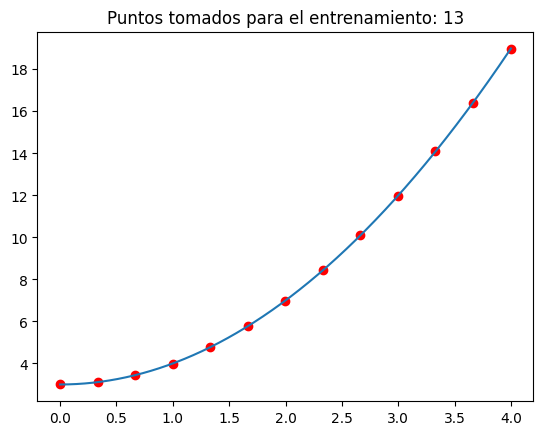

In [247]:
# Visualización de la función exacta junto con los puntos usados para entrenamiento
plt.figure()
plt.plot(t,y)
plt.scatter(t_data,y_data, c="red")
plt.title(f'Puntos tomados para el entrenamiento: {len(t_data)}')
plt.show()

### PINN

In [248]:
# Calcular la derivada
def calcul_derivadas(model, x):
    x.requires_grad_(True)           # Activar el flag requires_grad para que se realice el seguimiento de gradientes
    y_predec = model(x)              # Predicciones del modelo para las entradas
    dy_dx = torch.autograd.grad(y_predec, x, grad_outputs=torch.ones_like(y_predec), create_graph=True)[0]
    return dy_dx, y_predec

# Calcular la condición inicial
def cond_inicial(model, x_inicial):
    return model(x_inicial)

In [249]:
# Función de pérdida
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, dy_dx_pred, pde_target, y, y_data):
        loss_pde = self.mse_loss(dy_dx_pred, pde_target)
        loss_initial_condition = self.mse_loss(y, y_data)
        total_loss = (6e-2)*loss_pde + loss_initial_condition
        return total_loss

In [250]:
# Entrenamiento de la red neuronal
def train(model, optimizer, loss_fn, t_data, t_pr, num_epoch):
  loss_history = []
  learning_rates= []

  for epoch in range(num_epoch):
    model.train()
    y = model(t_data)                         # Datos de entrenamiento + condición inicial
    # yhp = model(t_p)                        # Evaluacion de la EDO
    dx, yhp = calcul_derivadas(model, t_pr)   # Calcular la derivada del modelo con respecto a t_pr
    pde_target = 2*t_pr                       # Definicion de la EDO
    loss = loss_fn(dx, pde_target, y, y_data)

    # Optimización
    optimizer.zero_grad()                     # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()                           # Retropropagación backward
    optimizer.step()                          # Actualización de los parámetros del modelo mediante el optimizador (optimizer)

    loss_history.append(loss.item())          # Almacenamiento del error


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)         # Almacenamiento del learning rate

    # Imprimir el progreso
    if (epoch + 1) % print_freq == 0:
      print(f'Epoch [{epoch+1}/{num_epoch}], Total Loss: {loss.item()}')

  return loss_history, learning_rates  # Devolver la lista de pérdida al final del entrenamiento y el lerning rate

In [251]:
# Instancia del modelo y del optimizador

# Creación del modelo con los parámetros definidos
# model = PINN(input_size, hidden_size, output_size)
# Necesitamos como datos de entrada:
# - input_size
# - hidden_size
# - output_size

# Parámetros del modelo
input_size = 1                                               # Número de entradas de la red
hidden_size = 5                                              # Número de neuronas en la capa oculta
#hidden_size = 60                                            # Opciones alternativas del tamaño de la capa oculta
#hidden_size = 200
output_size = 1                                              # Número de salidas de la red

# Tasa de aprendizaje
# learnig_rate = 0.001
learnig_rate = 0.01

model = PINN(input_size, hidden_size, output_size)

# Definición del optimizador para la actualización de los pesos de la red
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)

# Función de pérdida para calcular el error de la red
loss_fn = PINNLoss()

# Generación datos de entrenamiento
t_pr = torch.linspace(0,1,8).view(-1,1).requires_grad_(True)
#t_p = torch.linspace(0,1,40).view(-1,1).requires_grad_(True) # 40 puntos equidistanciados
#t_p = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)
#t_p = torch.linspace(0,1,1000).view(-1,1).requires_grad_(True)

start_time = time.time()                                      # Tiempo de inicio

# Número de iteraciones:
num_epoch = 12000
#num_epoch = 40000                                            # Otras opciones
#num_epoch = 30000
#num_epoch = 35000
#num_epoch = 48000
#num_epoch = 22000
#num_epoch =15000
#num_epoch = 10000
#num_epoch = 1000000                                          # Muchísimas épocas (no recomendable en muchos casos)
#num_epoch = 5000

# Entrenamos el modelo utilizando la función de entrenamiento
loss_history, learning_rates = train(model, optimizer, loss_fn, t_data, t_pr, num_epoch)

end_time = time.time()                                        # Tiempo de finalización

# Calculamos el tiempo transcurrido durante el entrenamiento
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

Epoch [2000/12000], Total Loss: 0.016497308388352394
Epoch [4000/12000], Total Loss: 0.0013334592804312706
Epoch [6000/12000], Total Loss: 0.0007554582552984357
Epoch [8000/12000], Total Loss: 0.00037803396116942167
Epoch [10000/12000], Total Loss: 0.00012690587027464062
Epoch [12000/12000], Total Loss: 6.54058821965009e-05
 
Tiempo de ejecución: 32.226006507873535 segundos


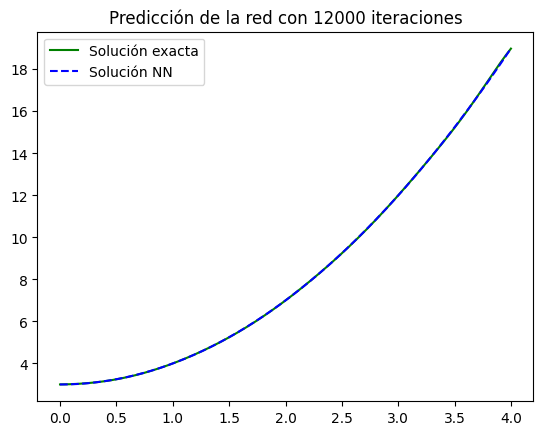

In [252]:
with torch.no_grad():     # Desactivar el cálculo de gradientes (modo evaluación)
  ypred = model(t)        # Predicción de la red neuronal con entrada t

# Gráfica
plt.figure()
plt.plot(t,ypred.detach(), c="green", label="Solución exacta")
plt.plot(t,y,c="blue", linestyle="--", label="Solución NN")
plt.legend()
plt.title(f'Predicción de la red con {num_epoch} iteraciones' )
plt.show()

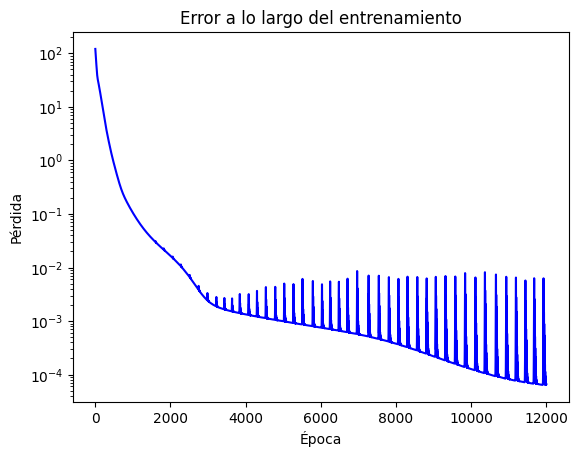

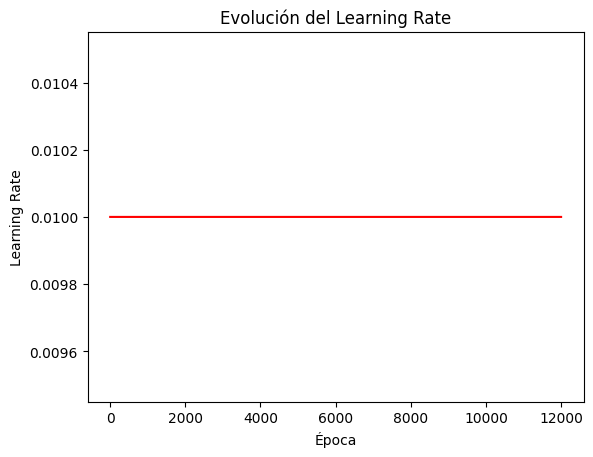

In [253]:
# Crear una figura con dos subgráficas
plt.figure()

# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')
plt.show()

plt.figure()
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Época')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')

# Mostrar la gráfica
plt.show()